In [9]:
from pandas import Series, DataFrame
import pandas as pd
import calendar
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [10]:
# Special packages
import statsmodels.api as sm
from patsy import dmatrices

# Setup

In [11]:
#read data in, appended 2014/2015, removed GO from col names
crime2014 = pd.read_csv("https://raw.githubusercontent.com/sxzhu/mis381_project/master/data/Austin_Crime_2014.csv", dtype=unicode, encoding='utf-8')
crime2014[:3]

crime2015 = pd.read_csv("https://raw.githubusercontent.com/sxzhu/mis381_project/master/data/Austin_Crime_2015.csv", dtype=unicode, encoding='utf-8')
crime = crime2014.append(crime2015,ignore_index=True)

crime = crime.rename(index=str, columns={"Highest NIBRS/UCR Offense Description": "General Offense Description",\
                                 "GO Highest Offense Desc":"Detailed Offense Description",\
                                 "GO Location":"Location","GO Report Date":"Report Date",\
                                 "GO Location Zip":"Zipcode","GO District":"District","GO Census Tract":"Census Tract",\
                                 "GO X Coordinate":"X Coordinate","GO Y Coordinate":"Y Coordinate",\
                                      "GO Primary Key":"Primary Key"})

crime = crime.drop('Location_1', axis=1)
crime['Date'] = pd.DatetimeIndex(crime['Report Date'])
crime['Month'] = pd.DatetimeIndex(crime['Date']).month
crime['Month'] = crime['Month'].apply(lambda x: calendar.month_abbr[x])
crime['Year'] = pd.DatetimeIndex(crime['Report Date']).year

## Merge Crimes

In [12]:
def merge_crimes(s):
    """Map some crimes together."""
    
    # Create a map of misspellings to correct spelling
    misspellings = {'Burglary / \nBreaking & Entering':'Burglary',
                    'Auto Theft':'Theft: Auto Parts',
                    'Homicide: Murder & Nonnegligent Manslaughter':'Murder',
                    'Agg Assault':'Aggravated Assault'}
    
    if s in misspellings:
        return misspellings[s]
    else:
        return s
    
# Apply the function to the Series
crime['General Offense Description'] = crime['General Offense Description'].map(merge_crimes)

def merge_theft(s):
    """Map some crimes together."""
    
    if (s[:5]=='Theft'):
        return s[:5]
    else:
        return s
    
# Apply the function to the Series
crime['General Offense Description'] = crime['General Offense Description'].map(merge_theft)

# Check that it worked
# mask = (crime['General Offense Description'] == 'Agg Assault')
# crime['General Offense Description'][mask]  # should be empty

crime['General Offense Description'].value_counts()

Theft                 61908
Burglary              10597
Aggravated Assault     3803
Robbery                1809
Rape                   1042
Murder                   55
Name: General Offense Description, dtype: int64

# Final Dataframe

In [35]:
#Add the 'Streetname' column to both dataframes, keeping only the street name information
# removes leading numbers, leading 'BLOCK', leading hyphenated or / numbers, trailing 'NB', 'SB', 'EB', 'WB', trailing 'SVRD', and leading 'N', 'S', 'E', 'W'

crime['Streetname'] = crime['Location'].str.rsplit('\n', -1).str[0].str.replace('^[/\s\d-]+/?\d*\s+', '').str.replace('^\d+[A-Z]\s+', '').str.replace('^BLOCK\s+', '').str.replace('\s[NSEW]B\s*$', '').str.replace('\sSVRD\s*$', '').str.replace('^\s*[NSEW]\s+', '').str.replace(' HALF ST', ' ST').str.rstrip()
crime['PrimaryStreet'] = crime['Streetname'].str.rsplit(' / ', -1).str[0]
crime['SecondaryStreet'] = crime['Streetname'].str.rsplit(' / ', -1).str[1]

In [36]:
crime['DayOfWeek'] = pd.DatetimeIndex(crime['Date']).weekday
crime['DayOfWeek'] = crime['DayOfWeek'].apply(lambda x: calendar.day_abbr[x])

In [37]:
len(crime['Zipcode'].value_counts())

48

In [38]:
df = crime
result = pd.crosstab(df['DayOfWeek'], [df['Month'], df['Zipcode']], dropna=False)
result

Month       Apr                                                        ...   \
Zipcode   78610 78613 78617 78652 78653 78660 78701 78702 78703 78704  ...    
DayOfWeek                                                              ...    
Fri           0     8    10     0     0     1    24    40    15    55  ...    
Mon           0     6     5     0     0     7    55    53    23    59  ...    
Sat           0     9    11     0     0     3    36    33     5    41  ...    
Sun           0     5     6     0     0     1    51    38    11    49  ...    
Thu           0     4     9     0     2     1    34    40    24    59  ...    
Tue           0    10     7     0     2     5    39    51    22    69  ...    
Wed           0    11     6     0     0     3    46    56    26    76  ...    

Month       Sep                                                        
Zipcode   78749 78750 78751 78752 78753 78754 78756 78757 78758 78759  
DayOfWeek                                                              
Fri          12     6    13    25    88     7    12    35    72    41  
Mon          18    17    13    32   118    13    13    20    61    40  
Sat          18     8    17    27    70     1     5    22    47    23  
Sun          18     3     9    24    70     4     2    17    32    16  
Thu          18    14    20    28    76    11     7    29    65    41  
Tue          23    17    31    40   103    11    14    27    70    33  
Wed          17     8    30    34    87     7     9    29    85    42  

[7 rows x 576 columns]

In [39]:
df = crime.drop_duplicates(subset='Date')
test = pd.crosstab(df['DayOfWeek'], [df['Month']], dropna=False)
test

Month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
DayOfWeek,,,,,,,,,,,,
Fri,8,9,8,8,10,9,8,8,10,8,10,8
Mon,8,9,9,8,8,8,10,10,8,9,8,9
Sat,8,10,8,8,9,8,8,9,10,9,9,8
Sun,8,10,8,8,8,8,9,10,9,10,8,8
Thu,9,8,9,8,10,10,8,8,9,8,10,8
Tue,9,8,10,8,8,9,9,9,8,8,8,10
Wed,10,8,10,8,9,10,8,8,8,8,9,9


In [77]:
final = pd.DataFrame((result/test).unstack()).reset_index()
final.columns = ['Month', 'Zipcode', 'Day', 'Average']
mask=(final['Month']=='Sep')
mask1=(final['Zipcode']=='78705')
mask2=(mask1&mask)
final1=final[mask2]
final1.index=final1['Day']
final1=final1.drop('Day',axis=1)
final1.reindex(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

,Month,Zipcode,Average
Day,,,
Mon,Sep,78705,4.888889
Tue,Sep,78705,4.500000
Wed,Sep,78705,5.222222
Thu,Sep,78705,3.000000
Fri,Sep,78705,3.875000
Sat,Sep,78705,1.500000
Sun,Sep,78705,2.375000


,Clearance Date,Clearance Status,Council District,Census Tract,District,Detailed Offense Description,Location,Zipcode,Primary Key,Report Date,X Coordinate,Y Coordinate,General Offense Description,Date,Month,Year,Streetname,PrimaryStreet,SecondaryStreet,DayOfWeek
0,04/28/2014 12:00:00 AM,N,1,18.350000000000001,E,AGG ROBBERY/DEADLY WEAPON,12151 N IH 35 SVRD NB ...,78753,20141061920,04/17/2014 12:00:00 AM,3135985,10117220,Robbery,2014-04-17,Apr,2014,IH 35,IH 35,NaN,Thu
1,05/20/2014 12:00:00 AM,N,1,21.13,I,ROBBERY BY ASSAULT,3300 BLOCK ROCKHURST LN ...,78723,20141150937,04/25/2014 12:00:00 AM,3137985,10087946,Robbery,2014-04-25,Apr,2014,ROCKHURST LN,ROCKHURST LN,NaN,Fri
2,05/13/2014 12:00:00 AM,N,3,9.02,C,ROBBERY BY THREAT,E 7TH ST / CHICON ST ...,78702,20141310316,05/11/2014 12:00:00 AM,3120890,10068910,Robbery,2014-05-11,May,2014,7TH ST / CHICON ST,7TH ST,CHICON ST,Sun
3,03/24/2015 12:00:00 AM,C,1,21.04,I,AGG ROBBERY/DEADLY WEAPON,WHELESS LN / BERKMAN DR ...,78723,20141670098,06/16/2014 12:00:00 AM,3130566,10089446,Robbery,2014-06-16,Jun,2014,WHELESS LN / BERKMAN DR,WHELESS LN,BERKMAN DR,Mon
4,10/02/2014 12:00:00 AM,N,3,9.02,G,AGG ROBBERY/DEADLY WEAPON,WALLER ST / E 2ND ST ...,78702,20142070292,07/26/2014 12:00:00 AM,3117732,10068195,Robbery,2014-07-26,Jul,2014,WALLER ST / E 2ND ST,WALLER ST,E 2ND ST,Sat
5,02/03/2014 12:00:00 AM,C,1,4.02,C,ROBBERY BY ASSAULT,1900 BLOCK MAPLE AVE ...,78722,2014210105,01/21/2014 12:00:00 AM,3122536,10075649,Robbery,2014-01-21,Jan,2014,MAPLE AVE,MAPLE AVE,NaN,Tue
6,08/27/2014 12:00:00 AM,N,9,11,G,ROBBERY BY ASSAULT,E 6TH ST / CONGRESS AVE ...,78701,20142321602,08/20/2014 12:00:00 AM,3114310,10070753,Robbery,2014-08-20,Aug,2014,6TH ST / CONGRESS AVE,6TH ST,CONGRESS AVE,Wed
7,11/18/2014 12:00:00 AM,C,4,18.04,E,ROBBERY BY THREAT,7800 N IH 35 SVRD SB ...,78753,20142571748,09/15/2014 12:00:00 AM,3127097,10097584,Robbery,2014-09-15,Sep,2014,IH 35,IH 35,NaN,Mon
8,10/22/2014 12:00:00 AM,N,3,23.18,H,AGG ROBBERY/DEADLY WEAPON,1900 BLOCK MONTOPOLIS DR ...,78741,20142610771,09/18/2014 12:00:00 AM,3127162,10055519,Robbery,2014-09-18,Sep,2014,MONTOPOLIS DR,MONTOPOLIS DR,NaN,Thu
9,10/14/2014 12:00:00 AM,N,9,11,G,ROBBERY BY ASSAULT,700 BLOCK E 6TH ST ...,78701,20142640694,09/21/2014 12:00:00 AM,3116520,10070158,Robbery,2014-09-21,Sep,2014,6TH ST,6TH ST,NaN,Sun


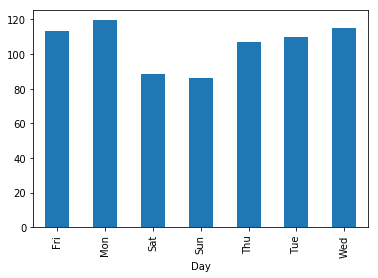

In [19]:
#final.groupby(['Month','Day'])['Average'].plot(kind='bar')
#split bar by zipcode 
#total crimes for austin on y axis on certain day
#graph for January, x-axis=M-F, bar=split by zipcode 
jan=final[final['Month']=='Jan']

# crime_wc = jan['Zipcode']=="78705"
# crime_ut = jan['Zipcode']=="78712"
# crime_hyde = jan['Zipcode']=="78751"
# crime_dt = jan['Zipcode']=="78701"
# student_mask = crime_wc | crime_ut | crime_hyde | crime_dt

# jan_student=jan[student_mask]

# pylab.rcParams['figure.figsize'] = (10, 8)

# test5 = jan_student.groupby(['Zipcode', 'Day'])['Average'].sum().unstack('Zipcode').fillna(0)
# test5.plot(kind='bar', stacked=True)

jan.groupby(['Day'])['Average'].sum().plot(kind='bar')
#sum- on avg X amount of crimes will occur in Austin on Monday

#panel showing jan-december
crime

In [20]:
jan=final[final['Month']=='Jan']
feb=final[final['Month']=='Feb']
mar=final[final['Month']=='Mar']
apr=final[final['Month']=='Apr']
may=final[final['Month']=='May']
jun=final[final['Month']=='Jun']
jul=final[final['Month']=='Jul']
aug=final[final['Month']=='Aug']
sep=final[final['Month']=='Sep']
octo=final[final['Month']=='Oct']
nov=final[final['Month']=='Nov']
dec=final[final['Month']=='Dec']


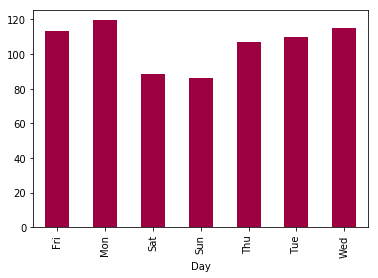

In [21]:
jan.groupby(['Day'])['Average'].sum().plot.bar(colormap='Spectral')
#(kind='bar', color='blue').set_title('January').set_ylabel('Expected Number of Crimes')


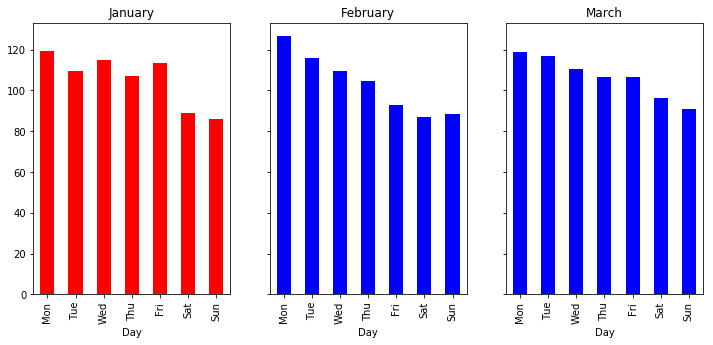

In [22]:
fig, (ax1, ax2, ax3) = subplots(nrows=1,
                                ncols=3,
                                sharex=False,
                                sharey=True,
                                figsize=(12,5))
#, apr, may, jun, jul, aug, sep, octo, nov, dec

# Each "axis" object corresponds to one subplot
# Fill in the subplots.

jan2=jan.groupby(['Day'])['Average'].sum().reindex(index=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
jan2.plot(kind='bar', color=['blue' if 'Day'=='Mon' else 'red'], stacked=True, ax=ax1).set(title='January')
jan
#color=plt.cm.Paired(np.arange(len(df))
# jan.set_title('January')
# jan.set_ylabel('Expected Number of Crimes')

feb.groupby(['Day'])['Average'].sum().reindex(index=['Mon','Tue','Wed','Thu','Fri','Sat','Sun']).plot(kind='bar', color='blue',ax=ax2).set(title='February')
# feb.set_title('Feb')
# feb.set_ylabel('Expected Number of Crimes')

mar.groupby(['Day'])['Average'].sum().reindex(index=['Mon','Tue','Wed','Thu','Fri','Sat','Sun']).plot(kind='bar', color='blue',ax=ax3).set(title='March')
# mar.set_title('March')
# mar.set_ylabel('Expected Number of Crimes')




show()

In [23]:
jan=final[final['Month']=='Jan']

crime_wc = jan['Zipcode']=="78705"
crime_ut = jan['Zipcode']=="78712"
crime_hyde = jan['Zipcode']=="78751"
crime_dt = jan['Zipcode']=="78701"
student_mask = crime_wc | crime_ut | crime_hyde | crime_dt

jan_student=jan[student_mask]
jan[:3]

# pylab.rcParams['figure.figsize'] = (10, 8)

# test5 = jan_student.groupby(['Zipcode', 'Day'])['Average'].sum().unstack('Zipcode').fillna(0).reindex(index=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
# test5.plot(kind='bar', stacked=True).set(title='Frequent Crimes in January Near Campus',ylabel='Y')

,Month,Zipcode,Day,Average
1344,Jan,78610,Fri,0.0
1345,Jan,78610,Mon,0.0
1346,Jan,78610,Sat,0.0


[<matplotlib.text.Text at 0x111986410>, <matplotlib.text.Text at 0x11194a250>]

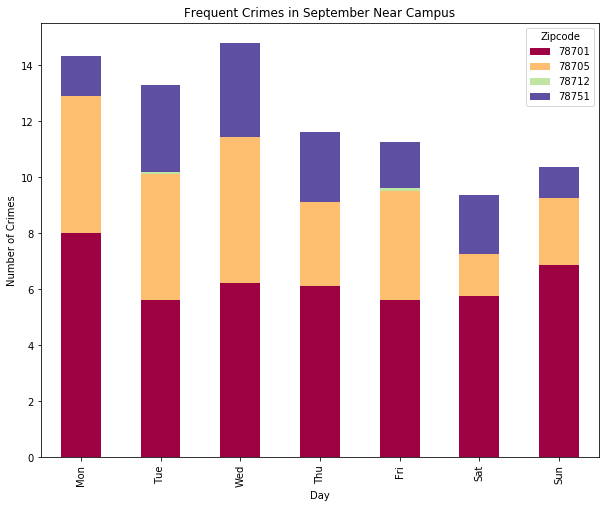

In [24]:
sept=final[final['Month']=='Sep']

crime_wc = sept['Zipcode']=="78705"
crime_ut = sept['Zipcode']=="78712"
crime_hyde = sept['Zipcode']=="78751"
crime_dt = sept['Zipcode']=="78701"
student_mask = crime_wc | crime_ut | crime_hyde | crime_dt

sept_student=sept[student_mask]

pylab.rcParams['figure.figsize'] = (10, 8)

test5 = sept_student.groupby(['Zipcode', 'Day'])['Average'].sum().unstack('Zipcode').fillna(0).reindex(index=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
test5.plot(kind='bar', stacked=True,colormap='Spectral').set(title='Frequent Crimes in September Near Campus',ylabel='Number of Crimes')

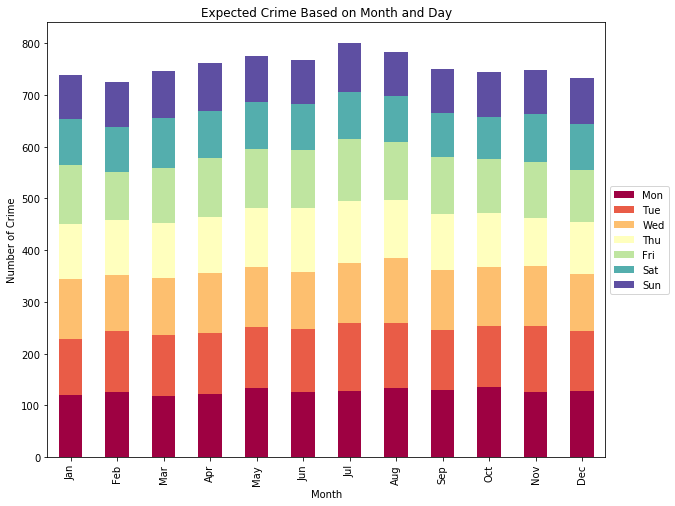

In [25]:
final_cont=final.groupby(['Month', 'Day'])['Average'].sum().unstack('Day')

final_cont=final_cont[['Mon','Tue','Wed','Thu','Fri','Sat','Sun']]

test6 = final_cont.reindex(index=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
test_plot=test6.plot(kind='bar', stacked=True,colormap='Spectral').legend(loc='center left', bbox_to_anchor=(1, 0.5))
title('Expected Crime Based on Month and Day')
ylabel('Number of Crime')

In [26]:
len(crime['Zipcode'].value_counts())

48

In [27]:
y, X = dmatrices('Average ~ Month + Zipcode + Day', data=final, return_type='dataframe')

In [28]:
model = sm.OLS(y, X)       # Set up the model
result = model.fit()       # Fit model (find the intercept and slopes)
print result.summary()

                            OLS Regression Results                            
Dep. Variable:                Average   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     817.2
Date:                Mon, 14 Aug 2017   Prob (F-statistic):               0.00
Time:                        12:56:34   Log-Likelihood:                -4383.2
No. Observations:                4032   AIC:                             8896.
Df Residuals:                    3967   BIC:                             9306.
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0364      0.092  

In [29]:
result.params

Intercept            0.036378
Month[T.Aug]         0.064881
Month[T.Dec]        -0.087698
Month[T.Feb]        -0.106572
Month[T.Jan]        -0.066534
Month[T.Jul]         0.114897
Month[T.Jun]         0.017402
Month[T.Mar]        -0.045271
Month[T.May]         0.040468
Month[T.Nov]        -0.039368
Month[T.Oct]        -0.054621
Month[T.Sep]        -0.036037
Zipcode[T.78613]     1.080985
Zipcode[T.78617]     0.750298
Zipcode[T.78652]     0.018981
Zipcode[T.78653]     0.061905
Zipcode[T.78660]     0.355126
Zipcode[T.78701]     5.672784
Zipcode[T.78702]     5.291733
Zipcode[T.78703]     1.901620
Zipcode[T.78704]     7.236276
Zipcode[T.78705]     3.401951
Zipcode[T.78712]     0.017791
Zipcode[T.78717]     0.672454
Zipcode[T.78719]     0.426257
Zipcode[T.78721]     1.532242
Zipcode[T.78722]     0.921495
Zipcode[T.78723]     5.760747
Zipcode[T.78724]     1.506647
Zipcode[T.78725]     0.162467
                      ...    
Zipcode[T.78731]     1.486210
Zipcode[T.78732]     0.002381
Zipcode[T.

In [30]:
result.pvalues[result.pvalues<0.05]

Month[T.Jul]         3.960744e-02
Zipcode[T.78613]     6.189523e-22
Zipcode[T.78617]     2.059913e-11
Zipcode[T.78660]     1.477931e-03
Zipcode[T.78701]     0.000000e+00
Zipcode[T.78702]     0.000000e+00
Zipcode[T.78703]     7.423996e-63
Zipcode[T.78704]     0.000000e+00
Zipcode[T.78705]    1.840686e-183
Zipcode[T.78717]     1.858197e-09
Zipcode[T.78719]     1.363725e-04
Zipcode[T.78721]     6.366867e-42
Zipcode[T.78722]     2.050487e-16
Zipcode[T.78723]     0.000000e+00
Zipcode[T.78724]     1.275567e-40
Zipcode[T.78726]     9.132137e-08
Zipcode[T.78727]     1.295714e-38
Zipcode[T.78729]     1.105309e-31
Zipcode[T.78731]     1.351780e-39
Zipcode[T.78735]     2.280732e-12
Zipcode[T.78739]     1.042304e-04
Zipcode[T.78741]     0.000000e+00
Zipcode[T.78744]     0.000000e+00
Zipcode[T.78745]     0.000000e+00
Zipcode[T.78746]     1.694386e-82
Zipcode[T.78747]     2.190615e-10
Zipcode[T.78748]    5.708041e-268
Zipcode[T.78749]     3.269039e-88
Zipcode[T.78750]     6.496077e-24
Zipcode[T.7875